In [251]:
%matplotlib inline

In [252]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display, clear_output

Введем некоторые константы

In [253]:
NUM_LABELS = 10
SEED = 42
INPUT_DIR = "./dz_data" # путь до данных для обучения
OUTPUT_FNAME = "submission.csv" # здесь должно быть записано имя выходного файла с ответами модели
CLS_LIST = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Загрузим данные для обучения и теста

In [254]:
X_train = np.load(f"{INPUT_DIR}/x_train.npy")
y_train = np.load(f"{INPUT_DIR}/y_train.npy")
X_test = np.load(f"{INPUT_DIR}/x_test.npy")

Посмотрим, как выглядят наши данные

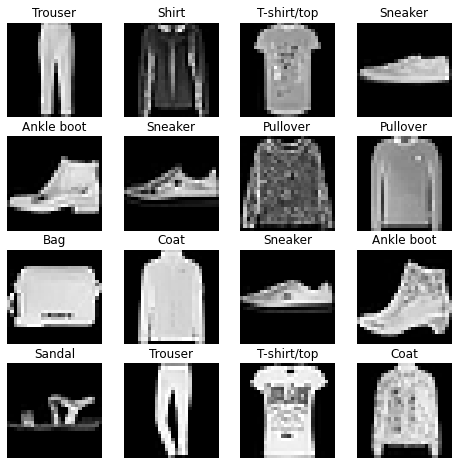

In [255]:
plt.figure(figsize=(8,8))
np.random.seed(SEED)
num_rc = 4
for i in range(16):
    idx = np.random.randint(X_train.shape[0])
    ax = plt.subplot(num_rc, num_rc, i + 1)
    ax.set_title(CLS_LIST[y_train[idx]])
    ax.set_axis_off()
    plt.imshow(X_train[idx].reshape(28,28), cmap='gray', vmin = 0, vmax = 255)

Разделим обучение на train и test

In [256]:
Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

Определим классы наших слоев

In [246]:
class Dense:
    def __init__(self, in_size, out_size):
        np.random.seed(1)
        self.W = np.random.normal(scale=0.1, size=(out_size, in_size))
        self.b = np.random.normal(scale=0.1, size=(out_size))
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    #def backward(self, dz, lr=0.001, lmbd = 0.0001):
    def backward(self, dz, lr=0.001, lmbd = 0.00025):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # обновляем веса
        #self.W = self.W - lr * self.dW
        self.W = self.W - lr * self.dW - lmbd * np.sign(self.W) * np.square(self.W)
        #self.b = self.b - lr * self.db
        self.b = self.b - lr * self.db - lmbd * np.sign(self.db) * np.square(self.db)
        # возвращаем dx для продолжения алгоритма
        return self.dx

In [52]:
class Max:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz

In [79]:
#Использовалась для сравнения ошибки на тестовой выборке
class Sigma:
    def forward(self, x):
        self.sigma = np.ones(x.shape[0]) / (1 + np.exp(-x + .00001))
        return np.ones(x.shape[0]) / (1 + np.exp(-x + .00001))
    
    def backward(self, dz, lr=0.1):
        return (1 - self.sigma) * self.sigma * dz

In [53]:
class Softmax:
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x)
        return exps / np.sum(exps)
    
    def backward(self, dz, lr=0.001):
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)

In [55]:
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum( y_true * np.log(y_hat))
    
    def backward(self, dz, lr=0.001):
        return dz * -1. * self.y_true / self.y_hat

Соберем сеть для классификации изображений

In [247]:
class FashionNet:
    
    def __init__(self):
        self.d1 = Dense(784, 1000)
        self.rl1 = Max()
        self.d2 = Dense(1000, 100)
        self.rl2 = Max()
        self.d3 = Dense(100, 100)
        self.rl3 = Max()
        self.d4 = Dense(100, 10)
        self.s = Softmax()
        
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.rl1.forward(net)
        net = self.d2.forward(net)
        net = self.rl2.forward(net)
        net = self.d3.forward(net)
        net = self.rl3.forward(net)
        net = self.d4.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.d4.backward(dz, lr)
        dz = self.rl3.backward(dz, lr)
        dz = self.d3.backward(dz, lr)
        dz = self.rl2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.rl1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz

Предобработаем наши данные

In [257]:
X_train = X_train.astype('float')
Xm = np.mean(X_train, axis=0)
Xs = np.std(X_train, axis=0)

Xt_train_mod = (Xt_train - Xm) / (Xs + 0.0001)
Xt_test_mod = (Xt_test - Xm) / (Xs + 0.0001)
X_test_mod = (X_test - Xm) / (Xs + 0.0001)

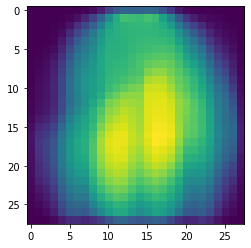

In [258]:
plt.imshow(Xm.reshape((28, 28)))

In [259]:
# заэнкодим наши ответы
t = OneHotEncoder(sparse=False)
yt_train_oh = t.fit_transform(yt_train.reshape(-1, 1))
yt_test_oh = t.fit_transform(yt_test.reshape(-1, 1))

In [248]:
net = FashionNet()
loss = CrossEntropy()

Лучший результат с использованием стохастического градиентного спуска:

<IPython.core.display.Javascript object>


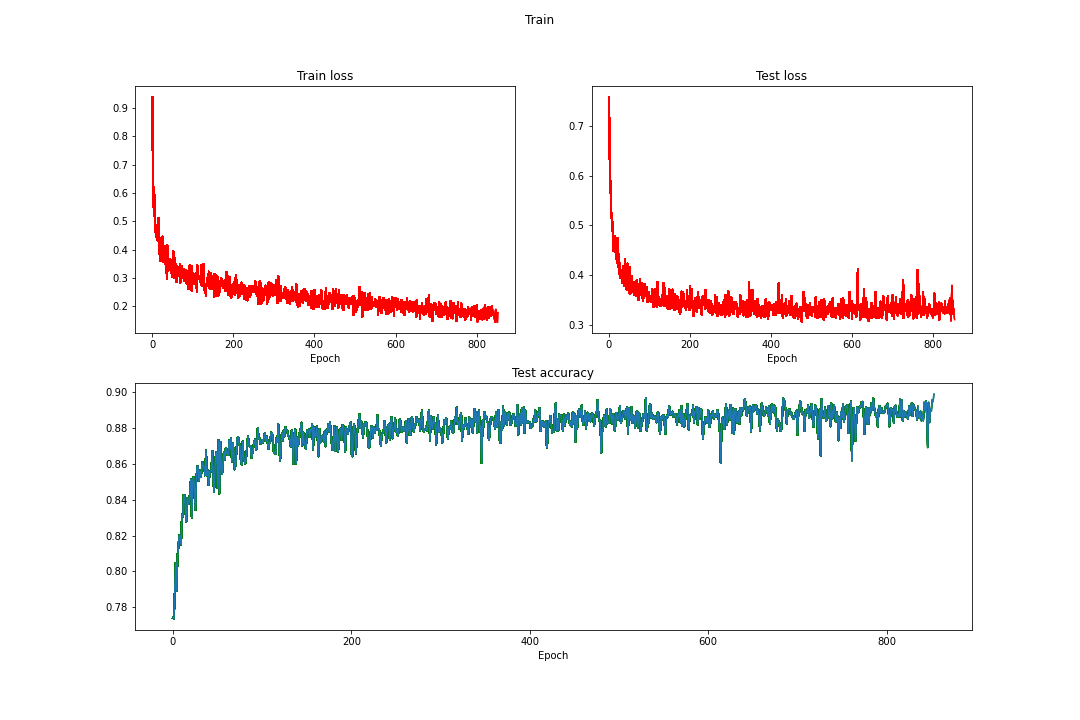

  0%|          | 0/10000 [00:00<?, ?it/s]

0.7741111111111111
0.7736666666666666
0.7886666666666666
0.8047777777777778
0.7892222222222223
0.8081111111111111
0.8141111111111111
0.82
0.8201111111111111
0.8151111111111111
0.8317777777777777
0.8306666666666667
0.8426666666666667
0.8424444444444444
0.833
0.8277777777777777
0.8408888888888889
0.8374444444444444
0.8385555555555556
0.8437777777777777
0.8512222222222222
0.8301111111111111
0.8498888888888889
0.8525555555555555
0.846
0.8343333333333334
0.8501111111111112
0.8583333333333333
0.8587777777777778
0.8505555555555555
0.8558888888888889
0.8524444444444444
0.8561111111111112
0.8607777777777778
0.8585555555555555
0.858
0.8535555555555555
0.8674444444444445
0.8533333333333334
0.8563333333333333
0.848
0.8551111111111112
0.8556666666666667
0.8563333333333333
0.8672222222222222
0.853
0.8443333333333334
0.8567777777777777
0.8652222222222222
0.8665555555555555
0.8463333333333334
0.8732222222222222
0.8434444444444444
0.8722222222222222
0.8585555555555555
0.8542222222222222
0.8606666666666

0.8877777777777778
0.8835555555555555
0.8856666666666667
0.8881111111111111
0.8866666666666667
0.881
0.8852222222222222
0.8874444444444445
0.8892222222222222
0.8955555555555555
0.886
0.884
0.8838888888888888
0.8661111111111112
0.878
0.8792222222222222
0.8868888888888888
0.8818888888888889
0.8806666666666667
0.8902222222222222
0.8824444444444445
0.883
0.8826666666666667
0.8906666666666667
0.8877777777777778
0.8824444444444445
0.8868888888888888
0.8876666666666667
0.8785555555555555
0.8815555555555555
0.8884444444444445
0.8856666666666667
0.8845555555555555
0.8875555555555555
0.8922222222222222
0.8826666666666667
0.8842222222222222
0.8867777777777778
0.8894444444444445
0.8894444444444445
0.8848888888888888
0.8894444444444445
0.8915555555555555
0.8768888888888889
0.8911111111111111
0.8845555555555555
0.8843333333333333
0.8917777777777778
0.8826666666666667
0.8867777777777778
0.8862222222222222
0.8797777777777778
0.8868888888888888
0.8892222222222222
0.8801111111111111
0.8884444444444445
0

In [230]:
%matplotlib notebook
from tqdm.auto import tqdm

lr = 0.002

L_train_acc = [] # массив для хранения лоссов на обучении за эпоху
L_test_acc = [] # массив для хранения лоссов на отложенном сете
Acc_test_acc = [] # массив для хранения точности на отложенном сете за эпоху

plot_mod = True
if plot_mod:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Train')

for iter in tqdm(range(10000)):
    # ЧАСТЬ 1:
    # проводим эпоху обучения, сохраняем средний лосс по всем примерам за эпоху
    # в переменной L_train_acc
    
    L_acc = 0.
    sh = list(range(Xt_train_mod.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    sh = sh[:1024]
    for i in range(len(sh)):
        x = Xt_train_mod[sh[i]]
        y = yt_train_oh[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_train_acc.append(L_acc / len(sh))
    
    # ЧАСТЬ 2:
    # Оцениваем сеть после одной эпохи на отложенной выборке
    # Сохраняем средний лосс в переменной L_test_acc
    # Сохраняем среднее значение accuracy в Acc_test_acc
    L_acc = 0.
    Acc = 0.
    for i in range(Xt_test_mod.shape[0]):
        x = Xt_test_mod[i]
        y = yt_test_oh[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L
        Acc += np.array_equal(y_h == np.max(y_h), y)
        
    L_test_acc.append(L_acc / Xt_test_mod.shape[0])
    Acc_test_acc.append(Acc / Xt_test_mod.shape[0])
    print(Acc_test_acc[-1])
    
    if plot_mod:
        ax1.plot(range(iter+1), L_train_acc, 'r-')
        ax1.set_title('Train loss')
        ax1.set_xlabel('Epoch')
        fig.canvas.draw()
        
        ax2.plot(range(iter+1), L_test_acc, 'r-')
        ax2.set_title('Test loss')
        ax2.set_xlabel('Epoch')
        fig.canvas.draw() 
        
        ax3.plot(range(iter+1), Acc_test_acc, 'g-')
        ax3.set_title('Test accuracy')
        ax3.set_xlabel('Epoch')
        fig.canvas.draw()
    if(Acc_test_acc[-1] > 0.8975):
        break
    
plt.plot(Acc_test_acc)

Лучший результат с использованием градиентного спуска:

<IPython.core.display.Javascript object>


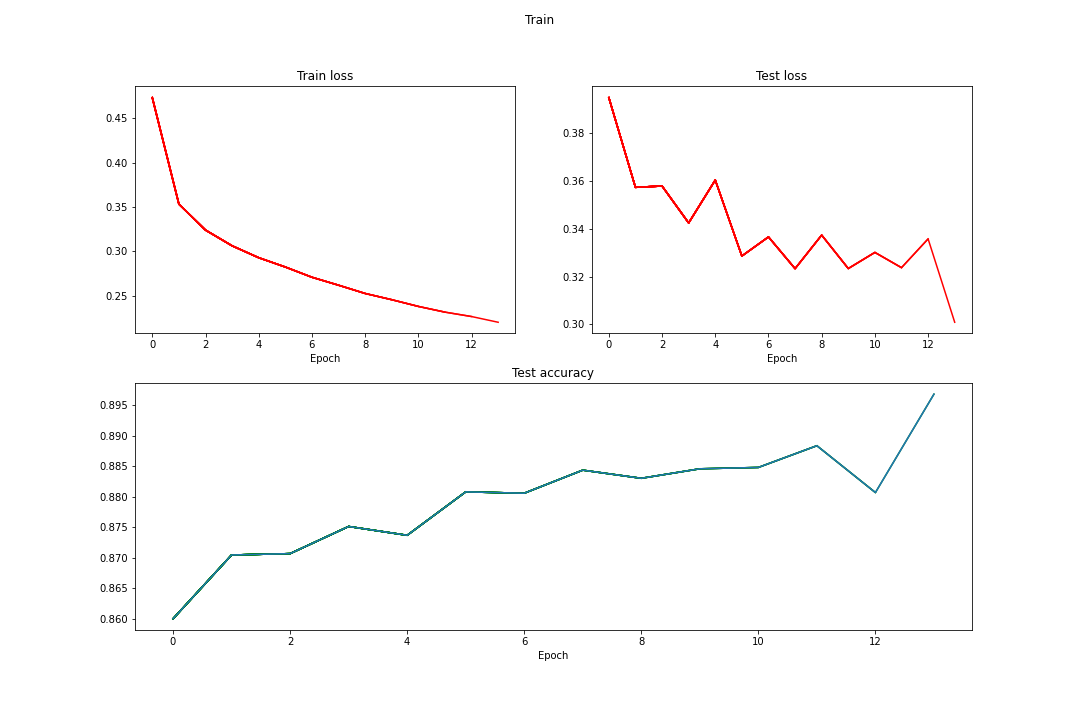

  0%|          | 0/70 [00:00<?, ?it/s]

0.86
0.8704444444444445
0.8706666666666667
0.8751111111111111
0.8736666666666667
0.8807777777777778
0.8805555555555555
0.8843333333333333
0.883
0.8845555555555555
0.8847777777777778
0.8883333333333333
0.8806666666666667
0.8967777777777778


In [221]:
%matplotlib notebook
from tqdm.auto import tqdm

loss = CrossEntropy()
lr = 0.002

L_train_acc = [] # массив для хранения лоссов на обучении за эпоху
L_test_acc = [] # массив для хранения лоссов на отложенном сете
Acc_test_acc = [] # массив для хранения точности на отложенном сете за эпоху

plot_mod = True
if plot_mod:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Train')

for iter in tqdm(range(70)):
    # ЧАСТЬ 1:
    # проводим эпоху обучения, сохраняем средний лосс по всем примерам за эпоху
    # в переменной L_train_acc
    
    L_acc = 0.
    sh = list(range(Xt_train_mod.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    for i in range(Xt_train_mod.shape[0]):
        x = Xt_train_mod[sh[i]]
        y = yt_train_oh[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_train_acc.append(L_acc / Xt_train_mod.shape[0])
    
    # ЧАСТЬ 2:
    # Оцениваем сеть после одной эпохи на отложенной выборке
    # Сохраняем средний лосс в переменной L_test_acc
    # Сохраняем среднее значение accuracy в Acc_test_acc
    L_acc = 0.
    Acc = 0.
    for i in range(Xt_test_mod.shape[0]):
        x = Xt_test_mod[i]
        y = yt_test_oh[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L
        Acc += np.array_equal(y_h == np.max(y_h), y)
        
    L_test_acc.append(L_acc / Xt_test_mod.shape[0])
    Acc_test_acc.append(Acc / Xt_test_mod.shape[0])
    print(Acc_test_acc[-1])
    
    if plot_mod:
        ax1.plot(range(iter+1), L_train_acc, 'r-')
        ax1.set_title('Train loss')
        ax1.set_xlabel('Epoch')
        fig.canvas.draw()
        
        ax2.plot(range(iter+1), L_test_acc, 'r-')
        ax2.set_title('Test loss')
        ax2.set_xlabel('Epoch')
        fig.canvas.draw() 
        
        ax3.plot(range(iter+1), Acc_test_acc, 'g-')
        ax3.set_title('Test accuracy')
        ax3.set_xlabel('Epoch')
        fig.canvas.draw()
    if(Acc_test_acc[-1] > 0.896):
        break
    
plt.plot(Acc_test_acc)

In [250]:
# формируем сабмишшен
with open(OUTPUT_FNAME, 'w') as fout: 
    fout.write("Id,Category\n")
    for i, x in tqdm(enumerate(X_test_mod)):
        n_out = net.forward(x)
        fout.write(f"{i},{np.argmax(n_out, axis=0)}\n")

0it [00:00, ?it/s]